In [1]:
# Hücre 1: Ortam & yardımcılar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from ocpy.oc_lmfit import OCLMFit

np.random.seed(42)

def make_synthetic_oc(n=150, *,
                      t0=2450000.0,
                      p_ref=0.12345,
                      quad_q=5e-8,
                      noise=0.0007,
                      wmin=10, wmax=50):
    """
    Tek eksen: 'cycle'
    Sentetik OC: lineer + kuadratik + küçük sinus + gürültü
    """
    cycle = np.arange(n, dtype=float)
    minimum_time = t0 + p_ref * cycle + np.random.normal(0.0, 2e-4, size=n)

    oc_linear = 3e-5 * (cycle - cycle.mean())
    oc_quad   = quad_q * (cycle - cycle.mean())**2
    oc_sin    = 8e-4 * np.sin(2*np.pi*cycle/35.0 + 0.4)
    oc = oc_linear + oc_quad + oc_sin + np.random.normal(0.0, noise, size=n)

    minimum_time_error = np.abs(np.random.normal(6e-4, 2e-4, size=n))
    weights = np.random.randint(wmin, wmax, size=n).astype(float)
    minimum_type = (np.random.rand(n) > 0.7).astype(int)
    labels = [f"P{i}" if mt == 0 else f"S{i}" for i, mt in enumerate(minimum_type)]

    oc_obj = OCLMFit(
        minimum_time=minimum_time.tolist(),
        minimum_time_error=minimum_time_error.tolist(),
        weights=weights.tolist(),
        minimum_type=minimum_type.tolist(),
        labels=labels,
        cycle=None,          # artik yok
        oc=oc.tolist(),
    )
    # Zorunlu eksen 'cycle' kolonunu ekleyelim (senin OC __init__'in otomatik eklemiyorsa)
    oc_obj["cycle"] = cycle
    return oc_obj

def show_df(df, title=None, head=10):
    if title:
        print(f"\n=== {title} ===")
    display(df.head(head))
    print(f"Satır sayısı: {len(df)}")

def scatter_with_errorbars(x, y, yerr=None, title="Scatter", xlabel="x", ylabel="y", s=16):
    plt.figure(figsize=(7,4))
    if yerr is not None:
        plt.errorbar(x, y, yerr=yerr, fmt='o', alpha=0.85, markersize=4)
    else:
        plt.scatter(x, y, s=s, alpha=0.8)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()



=== OC (FULL) - İlk 10 satır ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,2.450000e+06,0.000434,12.0,0,P0,0.0,-0.001471
1,2.450000e+06,0.000488,41.0,0,P1,1.0,-0.001254
2,2.450000e+06,0.000749,12.0,0,P2,2.0,-0.001838
3,2.450000e+06,0.000722,36.0,1,S3,3.0,-0.001081
4,2.450000e+06,0.000596,38.0,1,S4,4.0,-0.000942
5,2.450001e+06,0.000623,41.0,1,S5,5.0,-0.001573
6,2.450001e+06,0.000856,28.0,0,P6,6.0,0.000282
7,2.450001e+06,0.000482,30.0,1,S7,7.0,-0.000668
8,2.450001e+06,0.000709,14.0,1,S8,8.0,-0.001836
9,2.450001e+06,0.000560,27.0,0,P9,9.0,-0.000569


Satır sayısı: 150


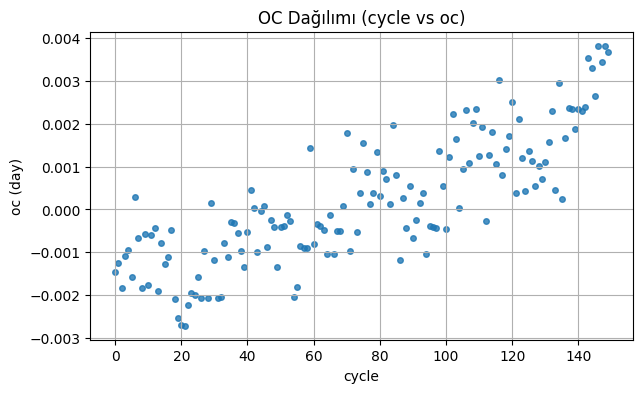

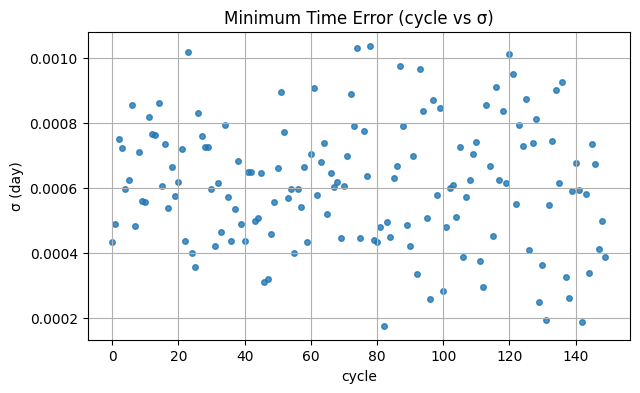

In [2]:
# Hücre 2: Sentetik veri oluştur + hızlı göz
oc_full = make_synthetic_oc(n=150)
show_df(oc_full.data, "OC (FULL) - İlk 10 satır")

# OC dağılımı: cycle vs oc
scatter_with_errorbars(
    oc_full.data["cycle"].to_numpy(dtype=float),
    oc_full.data["oc"].to_numpy(dtype=float),
    yerr=None,
    title="OC Dağılımı (cycle vs oc)",
    xlabel="cycle",
    ylabel="oc (day)"
)

# Hata barları: cycle vs minimum_time_error
scatter_with_errorbars(
    oc_full.data["cycle"].to_numpy(dtype=float),
    oc_full.data["minimum_time_error"].to_numpy(dtype=float),
    yerr=None,
    title="Minimum Time Error (cycle vs σ)",
    xlabel="cycle",
    ylabel="σ (day)"
)


In [3]:
# Hücre 3 (DÜZELTİLMİŞ) — __getitem__ testleri (int, boolean mask)

# int ile tek satır
single = oc_full[5]
print("Tek satırlık OC uzunluğu:", len(single))
show_df(single.data, "single.data")

# boolean mask ile alt küme
mask = oc_full.data["cycle"].to_numpy(dtype=float) < 50
subset = oc_full[mask]
print("Mask ile subset uzunluğu:", len(subset))
show_df(subset.data, "subset.data")

# slice benzeri: cycle < 30 için yine boolean mask kullan
subset2 = oc_full[oc_full.data["cycle"] < 30]
print("Mask ile subset2 uzunluğu:", len(subset2))
show_df(subset2.data, "subset2.data")


Tek satırlık OC uzunluğu: 1

=== single.data ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,2.450001e+06,0.000623,41.0,1,S5,5.0,-0.001573


Satır sayısı: 1
Mask ile subset uzunluğu: 50

=== subset.data ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,2.450000e+06,0.000434,12.0,0,P0,0.0,-0.001471
1,2.450000e+06,0.000488,41.0,0,P1,1.0,-0.001254
2,2.450000e+06,0.000749,12.0,0,P2,2.0,-0.001838
3,2.450000e+06,0.000722,36.0,1,S3,3.0,-0.001081
4,2.450000e+06,0.000596,38.0,1,S4,4.0,-0.000942
5,2.450001e+06,0.000623,41.0,1,S5,5.0,-0.001573
6,2.450001e+06,0.000856,28.0,0,P6,6.0,0.000282
7,2.450001e+06,0.000482,30.0,1,S7,7.0,-0.000668
8,2.450001e+06,0.000709,14.0,1,S8,8.0,-0.001836
9,2.450001e+06,0.000560,27.0,0,P9,9.0,-0.000569


Satır sayısı: 50
Mask ile subset2 uzunluğu: 30

=== subset2.data ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,2.450000e+06,0.000434,12.0,0,P0,0.0,-0.001471
1,2.450000e+06,0.000488,41.0,0,P1,1.0,-0.001254
2,2.450000e+06,0.000749,12.0,0,P2,2.0,-0.001838
3,2.450000e+06,0.000722,36.0,1,S3,3.0,-0.001081
4,2.450000e+06,0.000596,38.0,1,S4,4.0,-0.000942
5,2.450001e+06,0.000623,41.0,1,S5,5.0,-0.001573
6,2.450001e+06,0.000856,28.0,0,P6,6.0,0.000282
7,2.450001e+06,0.000482,30.0,1,S7,7.0,-0.000668
8,2.450001e+06,0.000709,14.0,1,S8,8.0,-0.001836
9,2.450001e+06,0.000560,27.0,0,P9,9.0,-0.000569


Satır sayısı: 30



=== cycle_norm eklendikten sonra ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc,cycle_norm
0,2.450000e+06,0.000434,12.0,0,P0,0.0,-0.001471,0.000000
1,2.450000e+06,0.000488,41.0,0,P1,1.0,-0.001254,0.006711
2,2.450000e+06,0.000749,12.0,0,P2,2.0,-0.001838,0.013423
3,2.450000e+06,0.000722,36.0,1,S3,3.0,-0.001081,0.020134
4,2.450000e+06,0.000596,38.0,1,S4,4.0,-0.000942,0.026846


Satır sayısı: 150

=== labels güncellendikten sonra ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc,cycle_norm
0,2.450000e+06,0.000434,12.0,0,BLA_P0,0.0,-0.001471,0.000000
1,2.450000e+06,0.000488,41.0,0,BLA_P1,1.0,-0.001254,0.006711
2,2.450000e+06,0.000749,12.0,0,BLA_P2,2.0,-0.001838,0.013423
3,2.450000e+06,0.000722,36.0,1,BLA_S3,3.0,-0.001081,0.020134
4,2.450000e+06,0.000596,38.0,1,BLA_S4,4.0,-0.000942,0.026846


Satır sayısı: 150


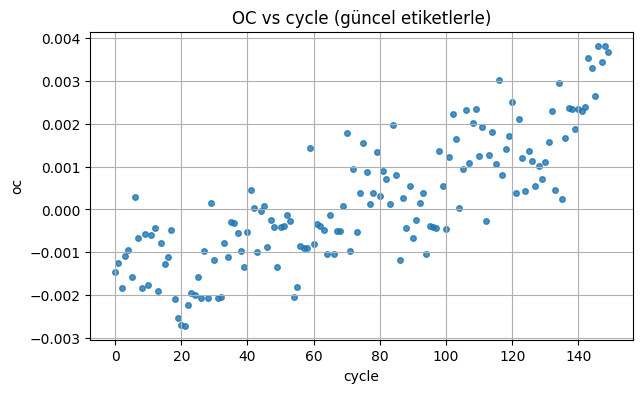

In [4]:
# Hücre 4: __setitem__ testleri

# Yeni bir kolon ekleyelim: örn. cycle_norm (0-1 ölçek)
c = oc_full.data["cycle"].to_numpy(dtype=float)
oc_full["cycle_norm"] = (c - c.min()) / (c.max() - c.min())
show_df(oc_full.data, "cycle_norm eklendikten sonra", head=5)

# Mevcut kolonu güncelle (örnek: labels'i "BLA_"+label yap)
new_labels = ["BLA_" + str(lab) for lab in oc_full.data["labels"]]
oc_full["labels"] = new_labels
show_df(oc_full.data, "labels güncellendikten sonra", head=5)

# Görsel kontrol: cycle vs oc
scatter_with_errorbars(
    oc_full.data["cycle"].to_numpy(dtype=float),
    oc_full.data["oc"].to_numpy(dtype=float),
    yerr=None,
    title="OC vs cycle (güncel etiketlerle)",
    xlabel="cycle",
    ylabel="oc"
)



=== Eşit Aralıklı Bin (8 kutu) ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,NaN,0.044065,NaN,None,Binned,8.900971,-0.001095
1,NaN,0.041667,NaN,None,Binned,28.076389,-0.001585
2,NaN,0.043153,NaN,None,Binned,47.292365,-0.000639
3,NaN,0.041204,NaN,None,Binned,65.183362,-0.000103
4,NaN,0.042993,NaN,None,Binned,83.842884,0.000343
5,NaN,0.043937,NaN,None,Binned,101.418919,0.000765
6,NaN,0.043602,NaN,None,Binned,121.788973,0.001258
7,NaN,0.047836,NaN,None,Binned,140.157895,0.002560


Satır sayısı: 8


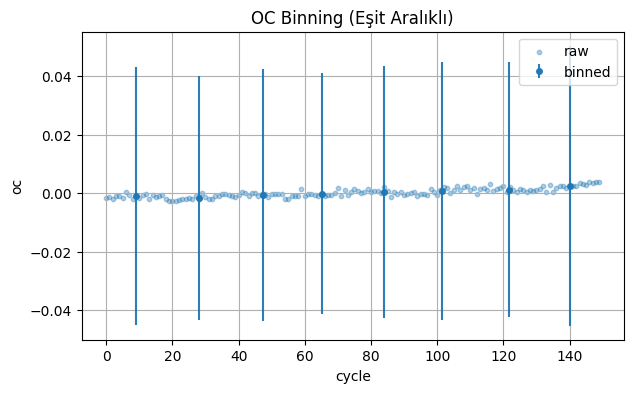


=== Smart Bin (8 hedef, smart_bin_period=50) ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,NaN,0.044065,NaN,None,Binned,8.900971,-0.001095
1,NaN,0.041667,NaN,None,Binned,28.076389,-0.001585
2,NaN,0.043153,NaN,None,Binned,47.292365,-0.000639
3,NaN,0.041204,NaN,None,Binned,65.183362,-0.000103
4,NaN,0.042993,NaN,None,Binned,83.842884,0.000343
5,NaN,0.043937,NaN,None,Binned,101.418919,0.000765
6,NaN,0.043602,NaN,None,Binned,121.788973,0.001258
7,NaN,0.047836,NaN,None,Binned,140.157895,0.002560


Satır sayısı: 8


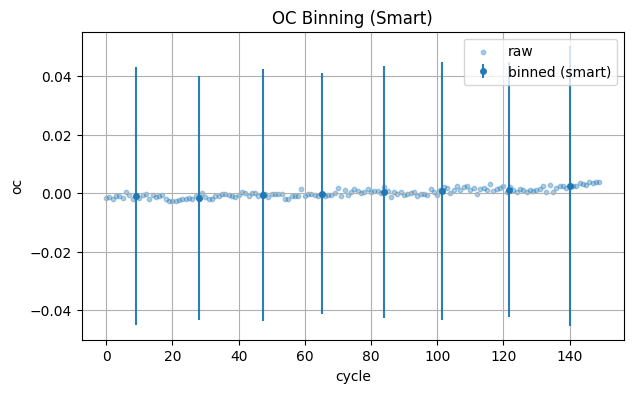

In [5]:
# Hücre 5: bin() testleri

# Eşit aralıklı bin (varsayılan)
b_eq = oc_full.bin(bin_count=8)
show_df(b_eq.data, "Eşit Aralıklı Bin (8 kutu)")

# Görselleştirme: orijinal + binned
plt.figure(figsize=(7,4))
plt.scatter(oc_full.data["cycle"], oc_full.data["oc"], s=10, alpha=0.35, label="raw")
bx = b_eq.data["cycle"].to_numpy(dtype=float)
by = b_eq.data["oc"].to_numpy(dtype=float)
byerr = b_eq.data["minimum_time_error"].to_numpy(dtype=float)
plt.errorbar(bx, by, yerr=byerr, fmt='o', markersize=4, alpha=0.95, label="binned")
plt.title("OC Binning (Eşit Aralıklı)")
plt.xlabel("cycle"); plt.ylabel("oc")
plt.grid(True); plt.legend(); plt.show()

# Smart bin (örnek: smart_bin_period=50.0)
def smart_bin_style(df, n):
    return oc_full._smart_bins(df, xcol="cycle", bin_count=int(n), smart_bin_period=50.0)

b_sm = oc_full.bin(bin_count=8, bin_style=smart_bin_style)
show_df(b_sm.data, "Smart Bin (8 hedef, smart_bin_period=50)")

plt.figure(figsize=(7,4))
plt.scatter(oc_full.data["cycle"], oc_full.data["oc"], s=10, alpha=0.35, label="raw")
bx = b_sm.data["cycle"].to_numpy(dtype=float)
by = b_sm.data["oc"].to_numpy(dtype=float)
byerr = b_sm.data["minimum_time_error"].to_numpy(dtype=float)
plt.errorbar(bx, by, yerr=byerr, fmt='o', markersize=4, alpha=0.95, label="binned (smart)")
plt.title("OC Binning (Smart)")
plt.xlabel("cycle"); plt.ylabel("oc")
plt.grid(True); plt.legend(); plt.show()


A uzunluk: 60 B uzunluk: 90

=== OC_A (head) ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,2.450000e+06,0.000434,12.0,0,BLA_P0,0.0,-0.001471
1,2.450000e+06,0.000488,41.0,0,BLA_P1,1.0,-0.001254
2,2.450000e+06,0.000749,12.0,0,BLA_P2,2.0,-0.001838
3,2.450000e+06,0.000722,36.0,1,BLA_S3,3.0,-0.001081
4,2.450000e+06,0.000596,38.0,1,BLA_S4,4.0,-0.000942
5,2.450001e+06,0.000623,41.0,1,BLA_S5,5.0,-0.001573
6,2.450001e+06,0.000856,28.0,0,BLA_P6,6.0,0.000282
7,2.450001e+06,0.000482,30.0,1,BLA_S7,7.0,-0.000668
8,2.450001e+06,0.000709,14.0,1,BLA_S8,8.0,-0.001836
9,2.450001e+06,0.000560,27.0,0,BLA_P9,9.0,-0.000569


Satır sayısı: 60

=== OC_B (head) ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,2.450007e+06,0.000704,26.0,0,BLA_P60,60.0,-0.000813
1,2.450008e+06,0.000907,22.0,0,BLA_P61,61.0,-0.000351
2,2.450008e+06,0.000578,29.0,1,BLA_S62,62.0,-0.000388
3,2.450008e+06,0.000680,34.0,0,BLA_P63,63.0,-0.000487
4,2.450008e+06,0.000738,13.0,0,BLA_P64,64.0,-0.001031
5,2.450008e+06,0.000520,19.0,1,BLA_S65,65.0,-0.000131
6,2.450008e+06,0.000645,12.0,1,BLA_S66,66.0,-0.001043
7,2.450008e+06,0.000603,27.0,0,BLA_P67,67.0,-0.000498
8,2.450008e+06,0.000620,45.0,0,BLA_P68,68.0,-0.000500
9,2.450009e+06,0.000445,31.0,0,BLA_P69,69.0,0.000069


Satır sayısı: 90
Merged uzunluk: 150  (A+B beklenir)

=== OC_MERGED (sorted by cycle) ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,2.450000e+06,0.000434,12.0,0,BLA_P0,0.0,-0.001471
1,2.450000e+06,0.000488,41.0,0,BLA_P1,1.0,-0.001254
2,2.450000e+06,0.000749,12.0,0,BLA_P2,2.0,-0.001838
3,2.450000e+06,0.000722,36.0,1,BLA_S3,3.0,-0.001081
4,2.450000e+06,0.000596,38.0,1,BLA_S4,4.0,-0.000942
5,2.450001e+06,0.000623,41.0,1,BLA_S5,5.0,-0.001573
6,2.450001e+06,0.000856,28.0,0,BLA_P6,6.0,0.000282
7,2.450001e+06,0.000482,30.0,1,BLA_S7,7.0,-0.000668
8,2.450001e+06,0.000709,14.0,1,BLA_S8,8.0,-0.001836
9,2.450001e+06,0.000560,27.0,0,BLA_P9,9.0,-0.000569


Satır sayısı: 150


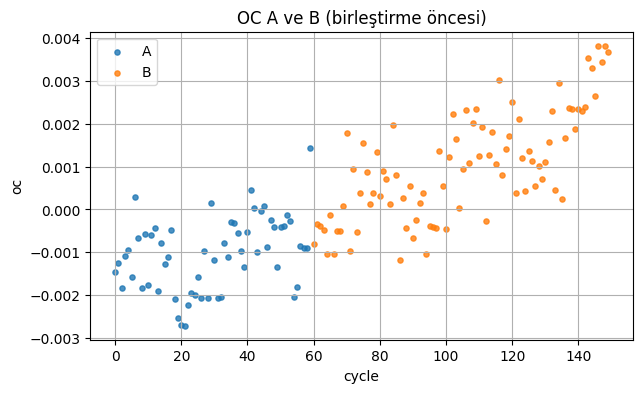

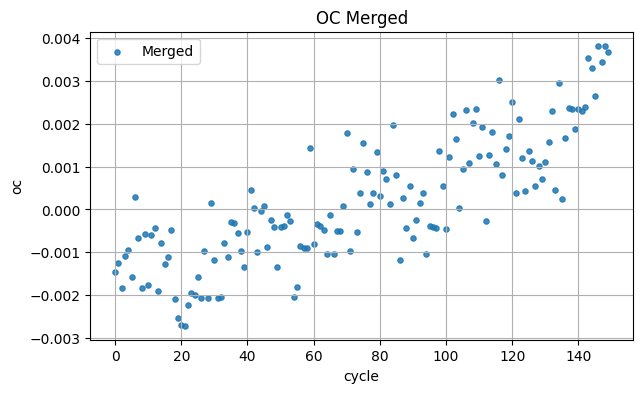

In [6]:
# Hücre 6: merge() testleri

mask_a = oc_full.data["cycle"] < 60
mask_b = ~mask_a

oc_A = oc_full[mask_a]
oc_B = oc_full[mask_b]

print("A uzunluk:", len(oc_A), "B uzunluk:", len(oc_B))
show_df(oc_A.data, "OC_A (head)")
show_df(oc_B.data, "OC_B (head)")

oc_merged = oc_A.merge(oc_B)
print("Merged uzunluk:", len(oc_merged), " (A+B beklenir)")
show_df(oc_merged.data.sort_values("cycle"), "OC_MERGED (sorted by cycle)")

plt.figure(figsize=(7,4))
plt.scatter(oc_A.data["cycle"], oc_A.data["oc"], s=14, alpha=0.8, label="A")
plt.scatter(oc_B.data["cycle"], oc_B.data["oc"], s=14, alpha=0.8, label="B")
plt.title("OC A ve B (birleştirme öncesi)")
plt.xlabel("cycle"); plt.ylabel("oc")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(7,4))
dfm = oc_merged.data.sort_values("cycle")
plt.scatter(dfm["cycle"], dfm["oc"], s=14, alpha=0.85, label="Merged")
plt.title("OC Merged")
plt.xlabel("cycle"); plt.ylabel("oc")
plt.grid(True); plt.legend(); plt.show()


Yazılan dosyalar:
C:\Users\Bar1\Desktop\oc_py_bar1\oc_py\src\eggs\chatgpt testing\_tmp_oc_tests_cycle\oc_sample.csv
C:\Users\Bar1\Desktop\oc_py_bar1\oc_py\src\eggs\chatgpt testing\_tmp_oc_tests_cycle\oc_sample.xlsx

=== OC from CSV ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,2.450000e+06,0.000434,12.0,0,BLA_P0,0.0,-0.001471
1,2.450000e+06,0.000488,41.0,0,BLA_P1,1.0,-0.001254
2,2.450000e+06,0.000749,12.0,0,BLA_P2,2.0,-0.001838
3,2.450000e+06,0.000722,36.0,1,BLA_S3,3.0,-0.001081
4,2.450000e+06,0.000596,38.0,1,BLA_S4,4.0,-0.000942
5,2.450001e+06,0.000623,41.0,1,BLA_S5,5.0,-0.001573
6,2.450001e+06,0.000856,28.0,0,BLA_P6,6.0,0.000282
7,2.450001e+06,0.000482,30.0,1,BLA_S7,7.0,-0.000668
8,2.450001e+06,0.000709,14.0,1,BLA_S8,8.0,-0.001836
9,2.450001e+06,0.000560,27.0,0,BLA_P9,9.0,-0.000569


Satır sayısı: 150

=== OC from XLSX (renamed cycles→cycle) ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,2.450000e+06,0.000434,12,0,BLA_P0,0,-0.001471
1,2.450000e+06,0.000488,41,0,BLA_P1,1,-0.001254
2,2.450000e+06,0.000749,12,0,BLA_P2,2,-0.001838
3,2.450000e+06,0.000722,36,1,BLA_S3,3,-0.001081
4,2.450000e+06,0.000596,38,1,BLA_S4,4,-0.000942
5,2.450001e+06,0.000623,41,1,BLA_S5,5,-0.001573
6,2.450001e+06,0.000856,28,0,BLA_P6,6,0.000282
7,2.450001e+06,0.000482,30,1,BLA_S7,7,-0.000668
8,2.450001e+06,0.000709,14,1,BLA_S8,8,-0.001836
9,2.450001e+06,0.000560,27,0,BLA_P9,9,-0.000569


Satır sayısı: 150


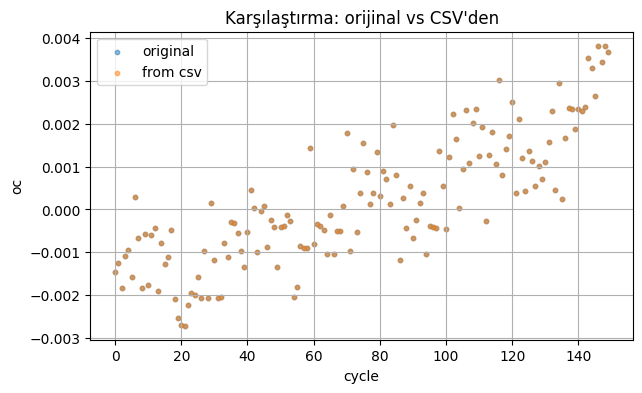

In [7]:
# Hücre 7: from_file() testleri

tmp_dir = Path("./_tmp_oc_tests_cycle")
tmp_dir.mkdir(exist_ok=True)

df_to_save = oc_full.data.copy()

# CSV kaydet
csv_path = tmp_dir / "oc_sample.csv"
df_to_save.to_csv(csv_path, index=False)

# XLSX kaydet
xlsx_path = tmp_dir / "oc_sample.xlsx"
df_to_save.to_excel(xlsx_path, index=False)

print("Yazılan dosyalar:")
print(csv_path.resolve())
print(xlsx_path.resolve())

# 1) CSV'den yükle (kolonlar zaten uyumlu)
oc_from_csv = oc_full.from_file(csv_path)
show_df(oc_from_csv.data, "OC from CSV")

# 2) XLSX: diyelim eski dosyada 'cycles' var; biz 'cycle' istiyoruz
df_alias = df_to_save.rename(columns={"cycle": "cycles"})
xlsx_alias_path = tmp_dir / "oc_alias.xlsx"
df_alias.to_excel(xlsx_alias_path, index=False)

# columns mapping: {"cycle": "cycles"} -> okurken 'cycles' => 'cycle'
oc_from_xlsx_alias = oc_full.from_file(xlsx_alias_path, columns={"cycle": "cycles"})
show_df(oc_from_xlsx_alias.data, "OC from XLSX (renamed cycles→cycle)")

# Görsel kıyas
plt.figure(figsize=(7,4))
plt.scatter(oc_full.data["cycle"], oc_full.data["oc"], s=10, alpha=0.5, label="original")
plt.scatter(oc_from_csv.data["cycle"], oc_from_csv.data["oc"], s=10, alpha=0.5, label="from csv")
plt.title("Karşılaştırma: orijinal vs CSV'den")
plt.xlabel("cycle"); plt.ylabel("oc")
plt.grid(True); plt.legend(); plt.show()


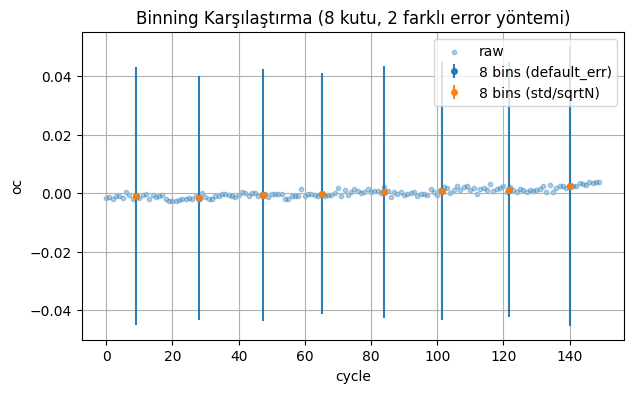


--- BinCount=4 / ErrorMode=default_err ---


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,NaN,0.030275,NaN,None,Binned,19.024748,-0.001354
1,NaN,0.029801,NaN,None,Binned,56.650977,-0.000359
2,NaN,0.030729,NaN,None,Binned,92.440038,0.000549
3,NaN,0.032225,NaN,None,Binned,130.124611,0.001849



--- BinCount=4 / ErrorMode=std/sqrtN ---


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,NaN,0.000162,NaN,None,Binned,19.024748,-0.001354
1,NaN,0.000164,NaN,None,Binned,56.650977,-0.000359
2,NaN,0.000164,NaN,None,Binned,92.440038,0.000549
3,NaN,0.000162,NaN,None,Binned,130.124611,0.001849



--- BinCount=8 / ErrorMode=default_err ---


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,NaN,0.044065,NaN,None,Binned,8.900971,-0.001095
1,NaN,0.041667,NaN,None,Binned,28.076389,-0.001585
2,NaN,0.043153,NaN,None,Binned,47.292365,-0.000639
3,NaN,0.041204,NaN,None,Binned,65.183362,-0.000103
4,NaN,0.042993,NaN,None,Binned,83.842884,0.000343
5,NaN,0.043937,NaN,None,Binned,101.418919,0.000765
6,NaN,0.043602,NaN,None,Binned,121.788973,0.001258
7,NaN,0.047836,NaN,None,Binned,140.157895,0.002560



--- BinCount=8 / ErrorMode=std/sqrtN ---


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,NaN,0.000229,NaN,None,Binned,8.900971,-0.001095
1,NaN,0.000229,NaN,None,Binned,28.076389,-0.001585
2,NaN,0.000236,NaN,None,Binned,47.292365,-0.000639
3,NaN,0.000229,NaN,None,Binned,65.183362,-0.000103
4,NaN,0.000229,NaN,None,Binned,83.842884,0.000343
5,NaN,0.000236,NaN,None,Binned,101.418919,0.000765
6,NaN,0.000229,NaN,None,Binned,121.788973,0.001258
7,NaN,0.000229,NaN,None,Binned,140.157895,0.002560



--- BinCount=12 / ErrorMode=default_err ---


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,NaN,0.051503,NaN,None,Binned,6.190981,-0.001008
1,NaN,0.056254,NaN,None,Binned,19.265823,-0.001917
2,NaN,0.050125,NaN,None,Binned,30.989950,-0.001234
3,NaN,0.055300,NaN,None,Binned,44.027523,-0.000474
4,NaN,0.047946,NaN,None,Binned,55.609195,-0.000644
5,NaN,0.052414,NaN,None,Binned,69.236264,0.000086
6,NaN,0.054313,NaN,None,Binned,80.221239,0.000544
7,NaN,0.048224,NaN,None,Binned,93.176744,-0.000089
8,NaN,0.058722,NaN,None,Binned,105.631034,0.001500
9,NaN,0.055641,NaN,None,Binned,118.256966,0.001472



--- BinCount=12 / ErrorMode=std/sqrtN ---


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,NaN,0.000277,NaN,None,Binned,6.190981,-0.001008
1,NaN,0.000289,NaN,None,Binned,19.265823,-0.001917
2,NaN,0.000277,NaN,None,Binned,30.989950,-0.001234
3,NaN,0.000289,NaN,None,Binned,44.027523,-0.000474
4,NaN,0.000277,NaN,None,Binned,55.609195,-0.000644
5,NaN,0.000289,NaN,None,Binned,69.236264,0.000086
6,NaN,0.000289,NaN,None,Binned,80.221239,0.000544
7,NaN,0.000277,NaN,None,Binned,93.176744,-0.000089
8,NaN,0.000289,NaN,None,Binned,105.631034,0.001500
9,NaN,0.000277,NaN,None,Binned,118.256966,0.001472


In [8]:
# Hücre 8: Farklı bin_error_method karşılaştırmaları

def inv_sqrt_sum_w(weights: np.ndarray) -> float:
    return float(1.0 / np.sqrt(np.sum(weights)))

def std_over_sqrt_n(weights: np.ndarray) -> float:
    N = len(weights)
    base = 1e-3
    return float(base/np.sqrt(max(N,1)))

bin_counts = [4, 8, 12]
bins_out = {}
for bc in bin_counts:
    bins_out[(bc, "default_err")] = oc_full.bin(bin_count=bc)  # default: inv sqrt(sum w)
    bins_out[(bc, "std/sqrtN")]   = oc_full.bin(bin_count=bc, bin_error_method=std_over_sqrt_n)

plt.figure(figsize=(7,4))
plt.scatter(oc_full.data["cycle"], oc_full.data["oc"], s=10, alpha=0.35, label="raw")

for label, oc_b in [("8 bins (default_err)", bins_out[(8, "default_err")]),
                    ("8 bins (std/sqrtN)",  bins_out[(8, "std/sqrtN")])]:
    bx = oc_b.data["cycle"].to_numpy(dtype=float)
    by = oc_b.data["oc"].to_numpy(dtype=float)
    byerr = oc_b.data["minimum_time_error"].to_numpy(dtype=float)
    plt.errorbar(bx, by, yerr=byerr, fmt='o', markersize=4, alpha=0.95, label=label)

plt.title("Binning Karşılaştırma (8 kutu, 2 farklı error yöntemi)")
plt.xlabel("cycle"); plt.ylabel("oc")
plt.grid(True); plt.legend(); plt.show()

# Tablo olarak hızlı kıyas
for key, oc_b in bins_out.items():
    bc, mode = key
    print(f"\n--- BinCount={bc} / ErrorMode={mode} ---")
    display(oc_b.data.head(10))



=== GAP verisi (sort by cycle) ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,2.450000e+06,0.000586,19.0,0,P0,0.0,-0.000908
1,2.450000e+06,0.000268,43.0,0,P1,1.0,-0.000921
2,2.450000e+06,0.000686,35.0,0,P2,2.0,-0.000100
3,2.450000e+06,0.000642,12.0,0,P3,3.0,-0.000799
4,2.450000e+06,0.000654,15.0,1,S4,4.0,0.000273
5,2.450001e+06,0.000345,14.0,1,S5,5.0,-0.001126
6,2.450001e+06,0.000384,14.0,0,P6,6.0,0.000840
7,2.450001e+06,0.000811,32.0,1,S7,7.0,0.000478
8,2.450001e+06,0.000592,18.0,1,S8,8.0,0.000329
9,2.450001e+06,0.000736,44.0,1,S9,9.0,0.000816


Satır sayısı: 60


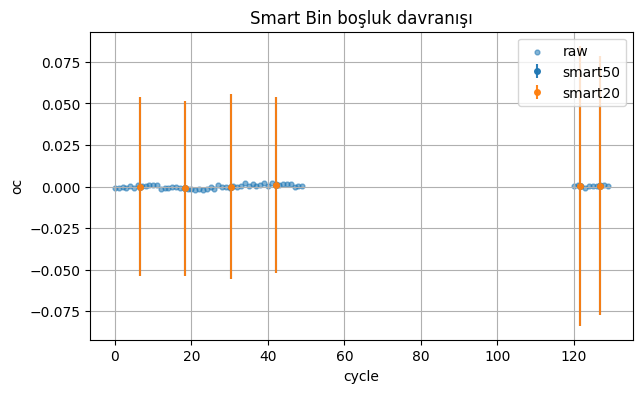


=== Smart50 Sonuç ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,NaN,0.053760,NaN,None,Binned,6.430636,0.000055
1,NaN,0.052778,NaN,None,Binned,18.454039,-0.001079
2,NaN,0.055902,NaN,None,Binned,30.262500,0.000049
3,NaN,0.052926,NaN,None,Binned,42.156863,0.001121
4,NaN,0.084215,NaN,None,Binned,121.602837,0.000537
5,NaN,0.077615,NaN,None,Binned,126.765060,0.000663


Satır sayısı: 6

=== Smart20 Sonuç ===


,minimum_time,minimum_time_error,weights,minimum_type,labels,cycle,oc
0,NaN,0.053760,NaN,None,Binned,6.430636,0.000055
1,NaN,0.052778,NaN,None,Binned,18.454039,-0.001079
2,NaN,0.055902,NaN,None,Binned,30.262500,0.000049
3,NaN,0.052926,NaN,None,Binned,42.156863,0.001121
4,NaN,0.084215,NaN,None,Binned,121.602837,0.000537
5,NaN,0.077615,NaN,None,Binned,126.765060,0.000663


Satır sayısı: 6


In [9]:
# Hücre 9: Veri içine boşluk ekleyip smart bin davranışı

oc_gap = make_synthetic_oc(n=60)
# cycle'ları iki parçaya ayırıp boşluk oluşturalım: 0..49 ve 120..129
oc_gap.data.loc[oc_gap.data.index >= 50, "cycle"] += 70.0

show_df(oc_gap.data.sort_values("cycle"), "GAP verisi (sort by cycle)")

def smart50(df, n): return oc_full._smart_bins(df, "cycle", n, smart_bin_period=50.0)
def smart20(df, n): return oc_full._smart_bins(df, "cycle", n, smart_bin_period=20.0)

b_s50 = oc_gap.bin(bin_count=6, bin_style=smart50)
b_s20 = oc_gap.bin(bin_count=6, bin_style=smart20)

plt.figure(figsize=(7,4))
dsg = oc_gap.data.sort_values("cycle")
plt.scatter(dsg["cycle"], dsg["oc"], s=12, alpha=0.55, label="raw")
for lbl, oc_b in [("smart50", b_s50), ("smart20", b_s20)]:
    bx = oc_b.data["cycle"].to_numpy(dtype=float)
    by = oc_b.data["oc"].to_numpy(dtype=float)
    byerr = oc_b.data["minimum_time_error"].to_numpy(dtype=float)
    plt.errorbar(bx, by, yerr=byerr, fmt='o', markersize=4, alpha=0.95, label=lbl)
plt.title("Smart Bin boşluk davranışı")
plt.xlabel("cycle"); plt.ylabel("oc")
plt.grid(True); plt.legend(); plt.show()

show_df(b_s50.data, "Smart50 Sonuç")
show_df(b_s20.data, "Smart20 Sonuç")


In [10]:
# Hücre 10: Sağlamlık kontrolleri

def basic_checks(oc_obj, name="OC"):
    df = oc_obj.data
    print(f"\n== {name} ==")
    print("Len:", len(df))
    print("Columns:", list(df.columns))
    print("NaN sayıları:\n", df.isna().sum())
    print("oc istatistikleri:\n", df["oc"].describe())
    if "cycle" in df.columns:
        print("cycle min/max:", float(df["cycle"].min()), float(df["cycle"].max()))

basic_checks(oc_full, "oc_full")
basic_checks(b_eq,    "b_eq")
basic_checks(b_sm,    "b_sm")
basic_checks(oc_merged, "oc_merged")



== oc_full ==
Len: 150
Columns: ['minimum_time', 'minimum_time_error', 'weights', 'minimum_type', 'labels', 'cycle', 'oc', 'cycle_norm']
NaN sayıları:
 minimum_time          0
minimum_time_error    0
weights               0
minimum_type          0
labels                0
cycle                 0
oc                    0
cycle_norm            0
dtype: int64
oc istatistikleri:
 count    1.500000e+02
mean     1.870933e-04
std      1.505151e-03
min     -2.718100e-03
25%     -9.050534e-04
50%     -1.992435e-07
75%      1.242724e-03
max      3.826825e-03
Name: oc, dtype: float64
cycle min/max: 0.0 149.0

== b_eq ==
Len: 8
Columns: ['minimum_time', 'minimum_time_error', 'weights', 'minimum_type', 'labels', 'cycle', 'oc']
NaN sayıları:
 minimum_time          8
minimum_time_error    0
weights               8
minimum_type          8
labels                0
cycle                 0
oc                    0
dtype: int64
oc istatistikleri:
 count    8.000000
mean     0.000188
std      0.001346
min    